In [41]:
!pip install prophet

In [42]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime
from prophet import Prophet


from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# DATA

In [43]:
df=pd.read_csv("META  BP DATA.csv")

In [44]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902
1,02-04-2014,63.209999,63.910000,62.209999,62.720001,66277000.0,4.0,-3.229999,3665.989990
2,03-04-2014,62.549999,63.169998,59.130001,59.490002,83859000.0,5.0,-2.740002,3637.580078
3,04-04-2014,59.939999,60.200001,56.320000,56.750000,125214400.0,6.0,0.200001,3539.379883
4,07-04-2014,55.900002,58.000000,55.439999,56.950001,108488000.0,2.0,1.239998,3507.750000


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


## Convert the "time" column to the datetime type

In [46]:
df["Date"] = pd.to_datetime(df["Date"])

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2205 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.5 KB


In [48]:
df.set_index('Date',inplace=True)

In [49]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902
2014-02-04,63.209999,63.910000,62.209999,62.720001,66277000.0,4.0,-3.229999,3665.989990
2014-03-04,62.549999,63.169998,59.130001,59.490002,83859000.0,5.0,-2.740002,3637.580078
2014-04-04,59.939999,60.200001,56.320000,56.750000,125214400.0,6.0,0.200001,3539.379883
2014-07-04,55.900002,58.000000,55.439999,56.950001,108488000.0,2.0,1.239998,3507.750000


# Missing entries


In [50]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [51]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [52]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [53]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [54]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [55]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2205 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 230.8 KB


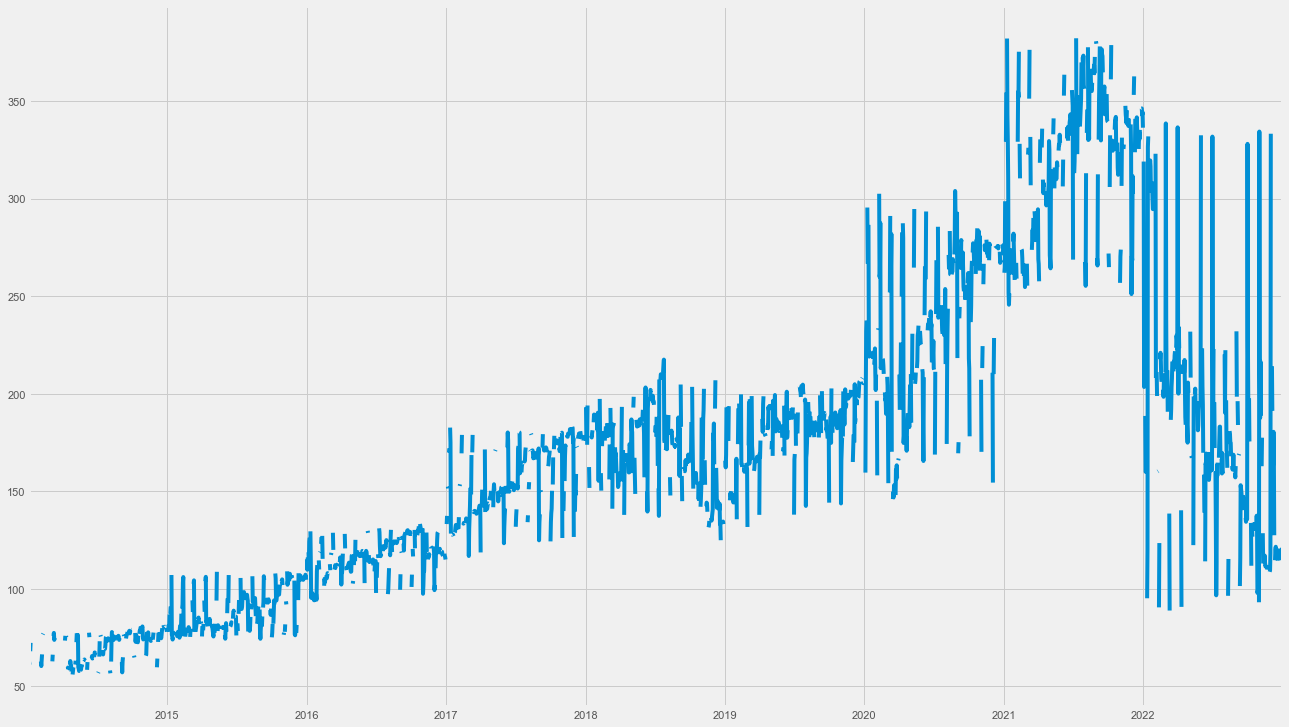

In [56]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [57]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ,ffilled
2014-01-04,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902,62.619999
2014-01-05,60.430000,62.279999,60.209999,61.150002,82429000.0,5.0,-0.690003,3594.360107,61.150002
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3594.360107,61.150002
2014-01-07,67.580002,68.440002,67.389999,68.059998,33243000.0,3.0,-1.610001,3894.330078,68.059998
2014-01-08,72.220001,73.220001,71.550003,72.360001,43535000.0,6.0,1.150001,3879.669922,72.360001
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3879.669922,72.360001
2014-01-10,78.779999,78.820000,75.900002,76.550003,55090000.0,4.0,0.529999,3984.739990,76.550003
2014-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3984.739990,76.550003
2014-01-12,77.260002,77.309998,74.800003,75.099998,31789900.0,2.0,0.360001,4287.810059,75.099998
2014-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4287.810059,75.099998


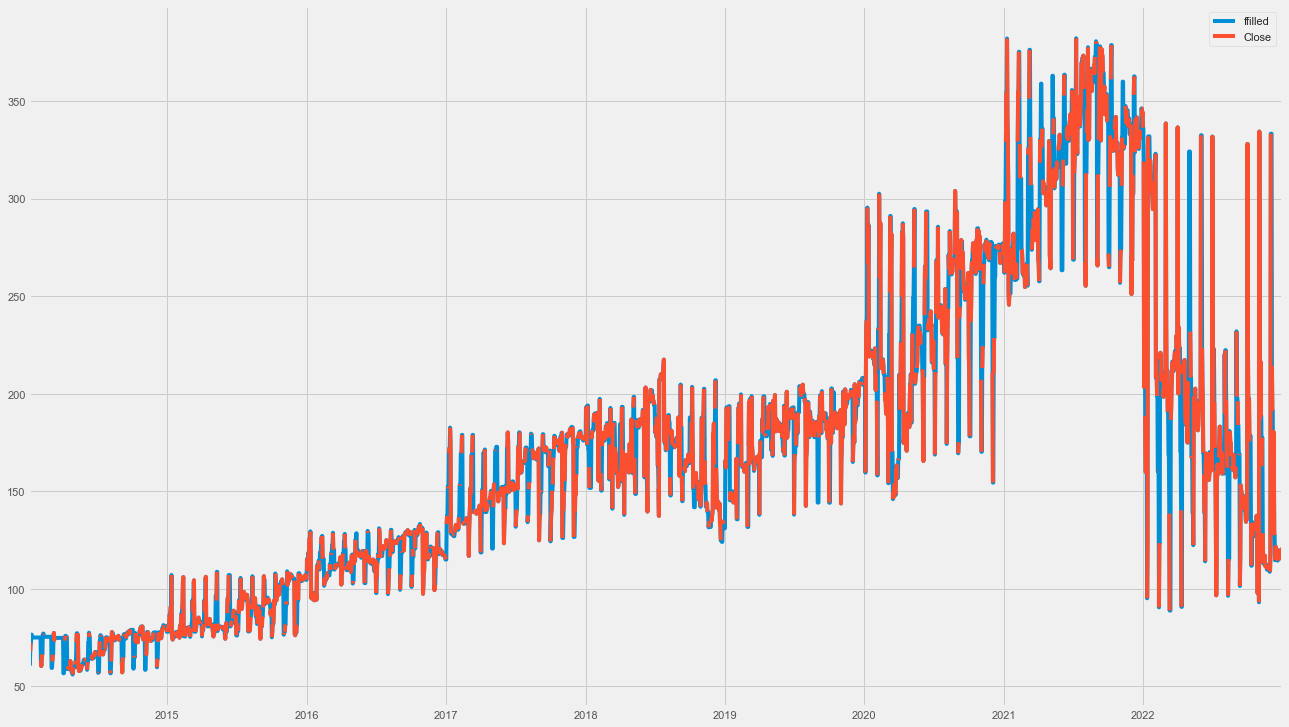

In [58]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [59]:
df.ffilled

2014-01-04     62.619999
2014-01-05     61.150002
2014-01-06     61.150002
2014-01-07     68.059998
2014-01-08     72.360001
                 ...    
2022-12-26    118.040001
2022-12-27    116.879997
2022-12-28    115.620003
2022-12-29    120.260002
2022-12-30    120.339996
Name: ffilled, Length: 3283, dtype: float64

In [60]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,62.619999,62.619999,3658.399902,0.100002
2014-01-05,61.150002,61.150002,3594.360107,-0.690003
2014-01-06,61.150002,NaN,3594.360107,NaN
2014-01-07,68.059998,68.059998,3894.330078,-1.610001
2014-01-08,72.360001,72.360001,3879.669922,1.150001
...,...,...,...,...
2022-12-26,118.040001,NaN,10985.450200,NaN
2022-12-27,116.879997,116.879997,10822.509770,-1.259994
2022-12-28,115.620003,115.620003,10679.339840,4.639999
2022-12-29,120.260002,120.260002,10951.049810,0.079994


In [61]:
df.drop(["Close"],axis=1,inplace=True)

In [62]:
df

,close,NASDAQ,Change
2014-01-04,62.619999,3658.399902,0.100002
2014-01-05,61.150002,3594.360107,-0.690003
2014-01-06,61.150002,3594.360107,NaN
2014-01-07,68.059998,3894.330078,-1.610001
2014-01-08,72.360001,3879.669922,1.150001
...,...,...,...
2022-12-26,118.040001,10985.450200,NaN
2022-12-27,116.879997,10822.509770,-1.259994
2022-12-28,115.620003,10679.339840,4.639999
2022-12-29,120.260002,10951.049810,0.079994


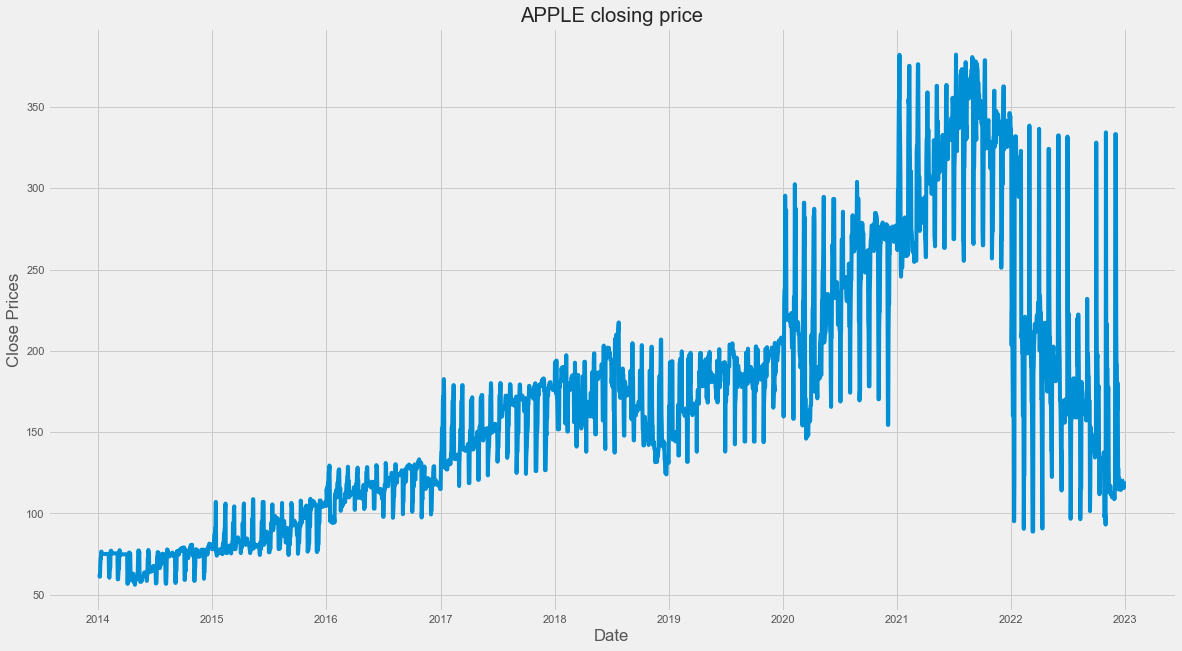

In [63]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# Time series features

In [64]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='close')
features_and_target = pd.concat([X, y], axis=1)

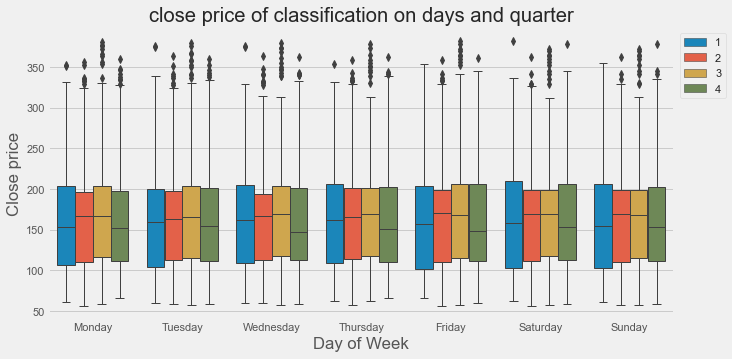

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='close',
            hue='quarter',
            ax=ax,
            linewidth=1)
ax.set_title('close price of classification on days and quarter')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Close price')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split


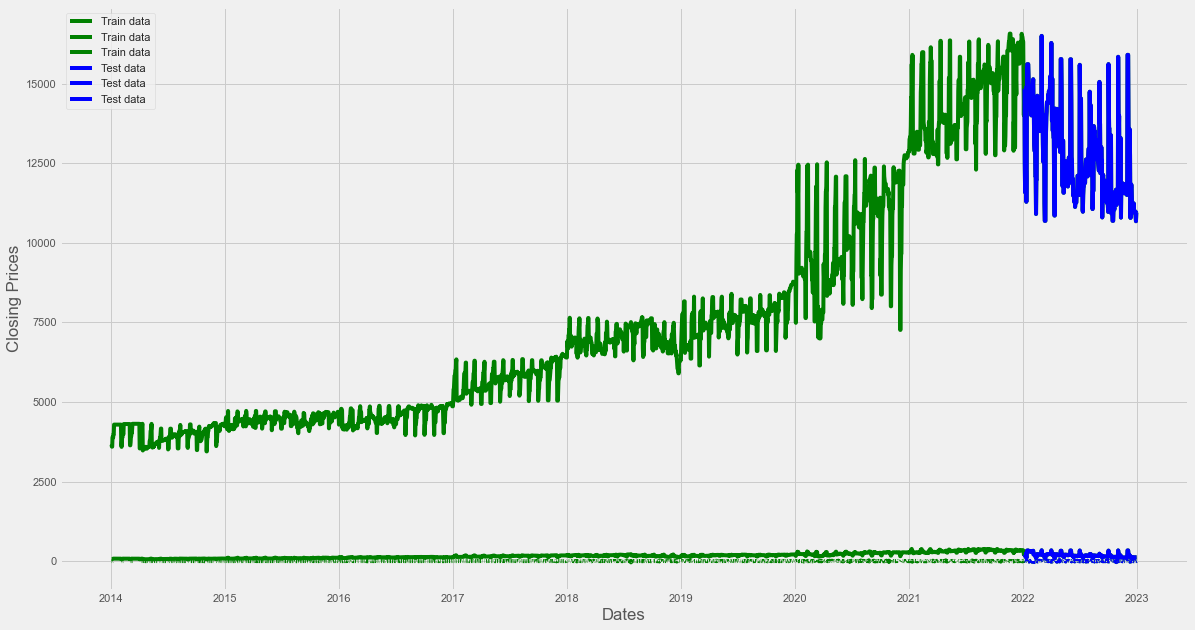

In [66]:
train = df.loc[df.index < '01-04-2022']
test = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

In [67]:
train.shape

(2922, 3)

In [68]:
test.shape

(361, 3)

# Simple Prophet Model


Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
Datetime column named: ds
target : y


In [69]:
# Format data for prophet model using ds and y
train_prophet =train.reset_index() \
    .rename(columns={'index':'ds',
                     'close':'y'})


In [70]:
train_prophet.head()

,ds,y,NASDAQ,Change
0,2014-01-04,62.619999,3658.399902,0.100002
1,2014-01-05,61.150002,3594.360107,-0.690003
2,2014-01-06,61.150002,3594.360107,NaN
3,2014-01-07,68.059998,3894.330078,-1.610001
4,2014-01-08,72.360001,3879.669922,1.150001


In [71]:
%%time
model = Prophet()
model.fit(train_prophet)


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\akash\AppData\Local\Temp\tmpb1w2k_ye\z_l57m27.json
DEBUG:cmdstanpy:input tempfile: C:\Users\akash\AppData\Local\Temp\tmpb1w2k_ye\y23jbzhr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\akash\\anaconda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=39506', 'data', 'file=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpb1w2k_ye\\z_l57m27.json', 'init=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpb1w2k_ye\\y23jbzhr.json', 'output', 'file=C:\\Users\\akash\\AppData\\Local\\Temp\\tmpb1w2k_ye\\prophet_modellubvtfni\\prophet_model-20230924193253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:32:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd

CPU times: total: 188 ms
Wall time: 933 ms


In [72]:
# Predict on test set with model
test_prophet = test.reset_index() \
    .rename(columns={'index':'ds',
                     'close':'y'})

test_fcst = model.predict(test_prophet)

In [73]:
test_fcst.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-04,360.588209,338.831171,390.994142,360.588209,360.588209,4.984428,4.984428,4.984428,0.311844,0.311844,0.311844,4.672585,4.672585,4.672585,0.0,0.0,0.0,365.572638
1,2022-01-05,360.816894,341.021024,391.401283,360.816894,360.816894,5.277698,5.277698,5.277698,0.220203,0.220203,0.220203,5.057495,5.057495,5.057495,0.0,0.0,0.0,366.094592
2,2022-01-06,361.045578,340.220885,391.293969,361.045578,361.045578,5.107914,5.107914,5.107914,-0.239592,-0.239592,-0.239592,5.347506,5.347506,5.347506,0.0,0.0,0.0,366.153491
3,2022-01-07,361.274262,343.285593,392.953259,361.274262,361.274262,5.260065,5.260065,5.260065,-0.284507,-0.284507,-0.284507,5.544572,5.544572,5.544572,0.0,0.0,0.0,366.534327
4,2022-01-08,361.502946,341.566019,392.288679,361.502946,361.502946,5.699586,5.699586,5.699586,0.047282,0.047282,0.047282,5.652304,5.652304,5.652304,0.0,0.0,0.0,367.202532


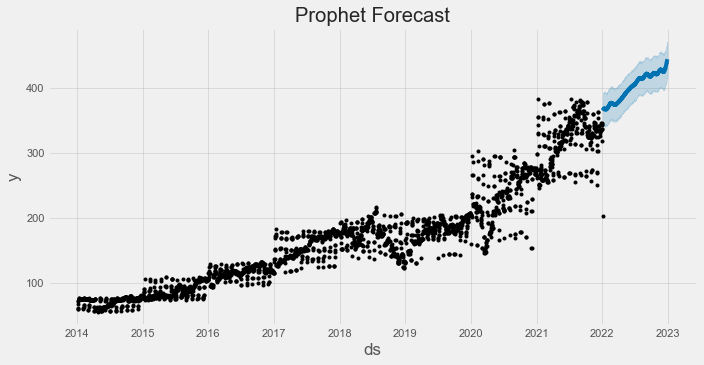

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()


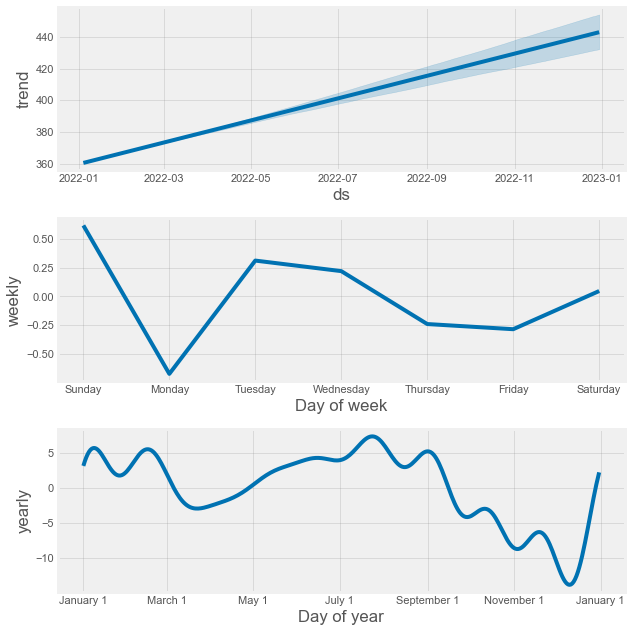

In [75]:
fig = model.plot_components(test_fcst)
plt.show()

# Compare Forecast to Actuals

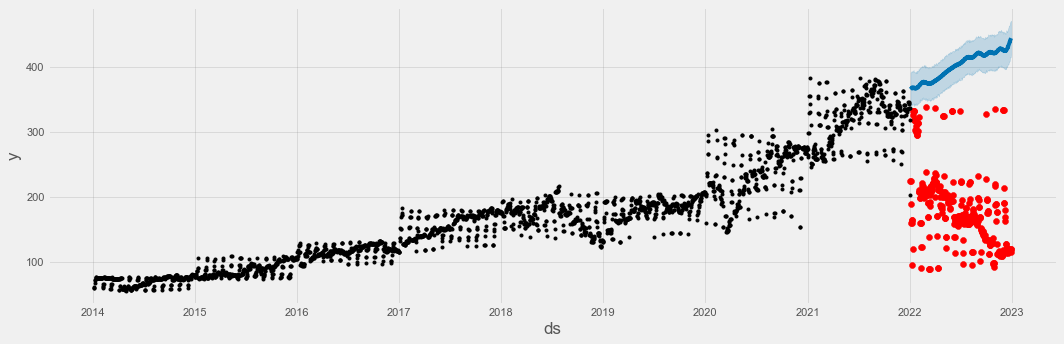

In [76]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

In [77]:
# plots

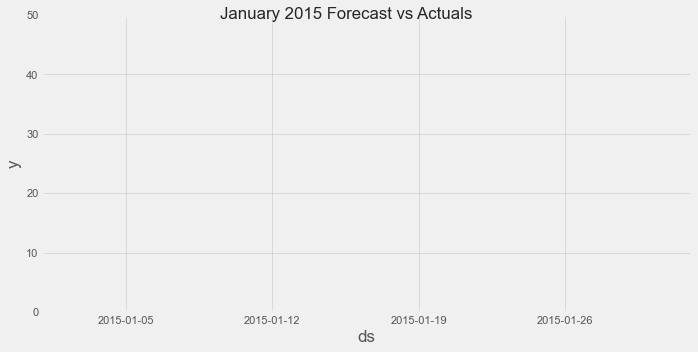

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_prophet.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

# Convert the date strings to datetime objects
lower_limit = pd.to_datetime('2015-01-01')
upper_limit = pd.to_datetime('2015-02-01')

ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(0, 50)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

plt.show()



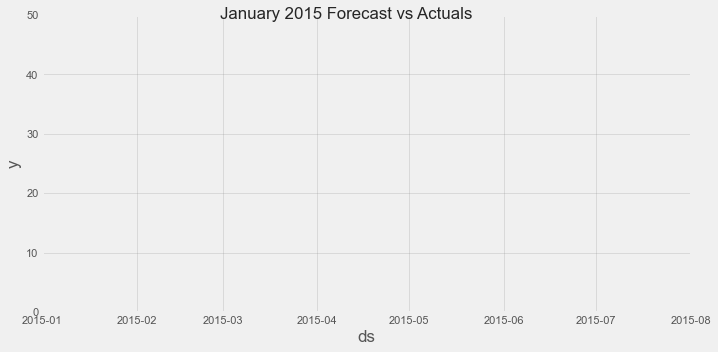

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_prophet.index, test_prophet['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

# Convert the date strings to datetime objects
lower_limit = pd.to_datetime('2015-01-01')
upper_limit = pd.to_datetime('2015-08-01')

ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(0, 50)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

plt.show()

# Evaluate the model with Error Metrics


In [80]:
# report performance
mse = mean_squared_error(test_fcst['yhat'], test_prophet['y'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_fcst['yhat'], test_prophet['y'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_fcst['yhat'], test_prophet['y']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_prophet['y'] - test_fcst['yhat'])/np.abs(test_fcst['yhat']))
print('MAPE: '+str(mape))

MSE: 53780.91553843558
MAE: 220.51930422612784
RMSE: 231.90712696774884
MAPE: 0.5435333138006948
